In [114]:
#### import global modules
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from yaml import safe_load
import google.oauth2.credentials
from google.cloud import bigquery
import gc

# Set global vars
pth_project = Path(os.getcwd().split('notebooks')[0])
pth_data = pth_project / 'data'
pth_queries = pth_project / 'core' / 'queries'
pth_creds = pth_project / 'conf' / 'local' / 'project_config.yaml'
sys.path.insert(0, str(pth_project))
d_project_config = safe_load(pth_creds.open())
# d_params = safe_load((pth_project / 'core' / 'parameters' / 'common.yaml').open())['data_extract']

# import local modules
from core.utils.gcp import connect_bq_services
# from core.etl.extract import extract_bq_data, extract_pr_codes, format_conv_df, filter_convs

# Connect to google services
bq_client = connect_bq_services(d_project_config['gcp-project-name'])
pd.options.display.max_rows = 100
from sklearn.model_selection import train_test_split


In [115]:
def extract_bq_data(bq_client, sql=None, pth_query=None):
    if sql is not None:
        df = bq_client.query(sql).to_dataframe()
    elif pth_query is not None:
        sql = pth_query.read_text()
        df = bq_client.query(sql).to_dataframe()
    else:
        raise ValueError('`sql` or `pth_query` should be set')  
    return df

In [116]:
Query= '''

select * from `divgpras-pr-579355.SHS.SHS_churn_model_train_data_dec22_feb23`

'''

In [117]:
DF=extract_bq_data(bq_client, sql=Query)

In [118]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514164 entries, 0 to 514163
Data columns (total 53 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Telus_ID                      514164 non-null  object 
 1   BAN                           514164 non-null  object 
 2   contract_start_date           372954 non-null  object 
 3   contract_end_date             514164 non-null  object 
 4   Intial_activation_date        514164 non-null  object 
 5   contract_end_status           514164 non-null  object 
 6   Contract_start_months         372954 non-null  Int64  
 7   dealer_customer_id            404535 non-null  object 
 8   customer_id                   404535 non-null  Int64  
 9   primary_login_id              404535 non-null  Int64  
 10  dealer_name                   514164 non-null  object 
 11  join_date                     404535 non-null  object 
 12  account_type_name             404535 non-nul

In [119]:
# DF.to_csv('SHS_churn_model_train_data_sep_nov_2022.csv',index=False)

In [128]:
# DF['login_consistency']=DF['login_consistency'].astype('int')

In [130]:
# DF['Best_Practices_1']=DF['Best_Practices_1'].fillna(0,inplace=True)
# DF['Best_Practices_2']=DF['Best_Practices_2'].fillna(0,inplace=True)
# DF['Best_Practices_3']=DF['Best_Practices_3'].fillna(0,inplace=True)
# DF['Best_Practices_4']=DF['Best_Practices_4'].fillna(0,inplace=True)
# DF['Best_Practices_5']=DF['Best_Practices_5'].fillna(0,inplace=True)
# DF['Best_Practices_6']=DF['Best_Practices_6'].fillna(0,inplace=True)
# DF['Best_Practice_All']=DF['Best_Practice_All'].fillna(0,inplace=True)

In [131]:
DF['Best_Practices_1'].value_counts()

1    346925
0     45323
Name: Best_Practices_1, dtype: Int64

In [132]:
ID_cols=['customer_id','dealer_customer_id','BAN']
ignore_cols=['primary_login_id','dealer_name','join_date','account_type_name','customer_type_name','cust_bus_cust_id'
             ,'contract_start_date','contract_end_date','customer_id_1','customer_id_2','customer_id_3','ban_1','ban_2'
             ,'BAN_3','sum_arm_commands','sum_disarm_commands','number_days_arming_disarming','count_of_dates_arming'
             ,'sum_login_count','number_of_login_days','count_of_dates_login','shs_count','Telus_Cust_ID','Best_Practice_All','Intial_activation_date','Telus_ID']

Target_col=['SMHM_Churn']

In [133]:
DF['Avg_SMHM_ARPU']=pd.to_numeric(DF['Avg_SMHM_ARPU'])
DF['Avg_FFH_ARPU']=pd.to_numeric(DF['Avg_FFH_ARPU'])
# DF['Avg_SMHM_ARPU']=pd.to_numeric(DF['Avg_SMHM_ARPU'])


In [134]:
# DF['Best_Practices_1']=DF['Best_Practices_1'].astype('category')
# DF['Best_Practices_2']=DF['Best_Practices_2'].astype('category')
# DF['Best_Practices_3']=DF['Best_Practices_3'].astype('category')
# DF['Best_Practices_4']=DF['Best_Practices_4'].astype('category')
# DF['Best_Practices_5']=DF['Best_Practices_5'].astype('category')
# DF['Best_Practices_6']=DF['Best_Practices_6'].astype('category')
# DF['Best_Practice_All']=DF['Best_Practice_All'].astype('category')
# DF['SMHM_Churn']=DF['SMHM_Churn'].astype('category')



In [135]:

num_cols=DF.select_dtypes(include=np.number).columns.tolist()
cat_cols=DF.select_dtypes(exclude=np.number).columns.tolist()

num_cols_features=list(set(num_cols)-set(ID_cols)-set(Target_col)-set(ignore_cols))
cat_cols_features=list(set(cat_cols)-set(ID_cols)-set(Target_col)-set(ignore_cols))
feature_cols=cat_cols_features+num_cols_features

In [136]:
len(feature_cols)

25

In [137]:
num_cols_features

['stv_count',
 'Avg_FFH_ARPU',
 'Contract_start_months',
 'Best_Practices_2',
 'sing_count',
 'Avg_disarm_per_day',
 'Interactivity_flag',
 'login_consistency',
 'Avg_arm_per_day',
 'Best_Practices_4',
 'arming_consistency',
 'product_mix_all',
 'Best_Practices_5',
 'Best_Practices_1',
 'Avg_login_per_day',
 'ADT_migrated_customer',
 'diic_count',
 'Tenure_months',
 'ttv_count',
 'Best_Practices_3',
 'hsic_count',
 'Best_Practices_6',
 'Avg_SMHM_ARPU']

In [138]:
cat_cols_features

['contract_end_status', 'Package']

In [139]:
DF[feature_cols].isnull().sum() * 100 / len(DF[feature_cols])

contract_end_status       0.000000
Package                   0.000000
stv_count                 0.000000
Avg_FFH_ARPU              4.972149
Contract_start_months    27.464000
Best_Practices_2         23.711501
sing_count                0.000000
Avg_disarm_per_day       63.762924
Interactivity_flag        0.000000
login_consistency        36.500222
Avg_arm_per_day          63.762924
Best_Practices_4         23.711501
arming_consistency       63.762924
product_mix_all           0.000000
Best_Practices_5         23.711501
Best_Practices_1         23.711501
Avg_login_per_day        36.500222
ADT_migrated_customer     0.000000
diic_count                0.000000
Tenure_months            21.321796
ttv_count                 0.000000
Best_Practices_3         23.711501
hsic_count                0.000000
Best_Practices_6         23.711501
Avg_SMHM_ARPU             5.018438
dtype: float64

In [140]:
pd.DataFrame(DF.groupby(['Package']).agg(
    
    Customer_count= ('Telus_ID','nunique'),
    SMHM_ARPU=('Avg_SMHM_ARPU','mean')
    # Email_Opened_count=('OPENED','sum'),
    # CT_Opened_count=('CLICKTHROUGH','sum'),
    # softbounce_count=('SOFTBOUNCE','sum'),
    # Hardbounce_count=('HARDBOUNCE','sum'),
    # # Unsub_count=('UNSUBSCRIBE','sum'),
    # campaign_date_min=('Campaign_date','min'),
    # campaign_date_max=('Campaign_date','max')

    
    # # Customer_Share= ('customer_id',lambda x:x.count()*100/Merge_DF_4.shape[0])
    # Churn_total=('Telus_Churn_Flag',lambda x: x.sum()),
    # Churn_rate=('Telus_Churn_Flag',lambda x: x.mean()*100)
).reset_index())

,Package,Customer_count,SMHM_ARPU
0,Monitored,256774,53.858516
1,Smart_Automation_Plus,102896,34.258555
2,Smart_Camera,44865,17.841552
3,Unknown_Package,109629,27.937491


In [141]:
DF['login_consistency'].isnull().sum()

187671

In [142]:
def login_consistency_cat(row):
    if row['login_consistency']>30:
        return 'Heavy_User'
    elif row['login_consistency']>0 and row['login_consistency']<=30:
        return 'Low_User'
    elif row['Interactivity_flag']==1:
        return 'No_User'
    elif row['Interactivity_flag']==0:
        return 'No_ADC_account'
    else:
        return 'None_of_the_above'
           

In [143]:
def arming_consistency_cat(row):
    if row['arming_consistency']>30:
        return 'Heavy_User'
    elif row['arming_consistency']>0 and row['arming_consistency']<=30:
        return 'Low_User'
    elif row['Interactivity_flag']==1:
        return 'No_User'
    elif row['Interactivity_flag']==0:
        return 'No_ADC_account'
    else:
        return 'None_of_the_above'

In [144]:
DF['login_consistency_cat']=DF.apply(login_consistency_cat,axis=1)

In [145]:
DF['arming_consistency_cat']=DF.apply(arming_consistency_cat,axis=1)

In [146]:
DF['login_consistency_cat'].value_counts()

Heavy_User        211945
Low_User          114548
No_ADC_account    109629
No_User            78042
Name: login_consistency_cat, dtype: int64

In [147]:
feature_cols_1=list(set(feature_cols)-set(['arming_consistency','login_consistency']))+['login_consistency_cat','arming_consistency_cat']


In [150]:
feature_cols_1

['stv_count',
 'Best_Practices_1',
 'Avg_login_per_day',
 'product_mix_all',
 'Package',
 'Avg_FFH_ARPU',
 'ADT_migrated_customer',
 'diic_count',
 'Contract_start_months',
 'Best_Practices_2',
 'sing_count',
 'Tenure_months',
 'Avg_disarm_per_day',
 'Interactivity_flag',
 'ttv_count',
 'Best_Practices_6',
 'Avg_arm_per_day',
 'contract_end_status',
 'Best_Practices_4',
 'Best_Practices_3',
 'hsic_count',
 'Best_Practices_5',
 'Avg_SMHM_ARPU',
 'login_consistency_cat',
 'arming_consistency_cat']

In [151]:
# DF.info()

In [152]:
DF[feature_cols_1].isnull().sum() * 100 / len(DF[feature_cols_1])

stv_count                  0.000000
Best_Practices_1          23.711501
Avg_login_per_day         36.500222
product_mix_all            0.000000
Package                    0.000000
Avg_FFH_ARPU               4.972149
ADT_migrated_customer      0.000000
diic_count                 0.000000
Contract_start_months     27.464000
Best_Practices_2          23.711501
sing_count                 0.000000
Tenure_months             21.321796
Avg_disarm_per_day        63.762924
Interactivity_flag         0.000000
ttv_count                  0.000000
Best_Practices_6          23.711501
Avg_arm_per_day           63.762924
contract_end_status        0.000000
Best_Practices_4          23.711501
Best_Practices_3          23.711501
hsic_count                 0.000000
Best_Practices_5          23.711501
Avg_SMHM_ARPU              5.018438
login_consistency_cat      0.000000
arming_consistency_cat     0.000000
dtype: float64

In [153]:
# DF[DF['login_consistency_cat']=='No_User'][['Telus_ID','customer_id','login_consistency','Interactivity_flag','login_consistency_cat']]

In [154]:
def impute_missing_values(dataset=DF):
    
    for cols in dataset.columns:
        if dataset[cols].dtype == np.dtype('O'):
            # df.loc[np.isnan(df["Age"]), 'Age'] = rand1
            #dataset.loc[dataset[cols].isnull(), cols]="Missing_category"
            dataset[cols]=dataset[cols].fillna("Missing_category",inplace=False)
        else:
            dataset[cols]=dataset[cols].fillna(0,inplace=False)
            #dataset.loc[dataset[cols].isnull(), cols]=0
    return dataset

 
DF[feature_cols_1]=impute_missing_values(dataset=DF[feature_cols_1])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [155]:
DF['SMHM_Churn'].value_counts()

0    511405
1      2759
Name: SMHM_Churn, dtype: Int64

In [156]:
def data_splitting(dataset=DF,feature_cols=[],Target=[],testsize=0.3):
    
    
    X=dataset[feature_cols]
    Y=dataset[Target]
    X1=pd.get_dummies(X,prefix_sep='__')
    X_train, X_validation, Y_train, Y_validation = train_test_split(X1, Y, test_size=testsize, random_state=11,stratify=Y)
    final_feature_columns=X_train.columns.tolist()
    print()
    print("Data splitting Completed.")
    return X_train,X_validation,Y_train,Y_validation,final_feature_columns
# %%
X_train,X_validation,Y_train,Y_validation,final_feature_columns=data_splitting(
dataset=DF,feature_cols=feature_cols_1,Target=Target_col,testsize=0.3)


Data splitting Completed.


In [157]:
X_train.shape

(359914, 36)

In [158]:
final_feature_columns

['stv_count',
 'Best_Practices_1',
 'Avg_login_per_day',
 'product_mix_all',
 'Avg_FFH_ARPU',
 'ADT_migrated_customer',
 'diic_count',
 'Contract_start_months',
 'Best_Practices_2',
 'sing_count',
 'Tenure_months',
 'Avg_disarm_per_day',
 'Interactivity_flag',
 'ttv_count',
 'Best_Practices_6',
 'Avg_arm_per_day',
 'Best_Practices_4',
 'Best_Practices_3',
 'hsic_count',
 'Best_Practices_5',
 'Avg_SMHM_ARPU',
 'Package__Monitored',
 'Package__Smart_Automation_Plus',
 'Package__Smart_Camera',
 'Package__Unknown_Package',
 'contract_end_status__contract_expired',
 'contract_end_status__contract_expiring_after_90_days',
 'contract_end_status__contract_expiring_within_90_days',
 'login_consistency_cat__Heavy_User',
 'login_consistency_cat__Low_User',
 'login_consistency_cat__No_ADC_account',
 'login_consistency_cat__No_User',
 'arming_consistency_cat__Heavy_User',
 'arming_consistency_cat__Low_User',
 'arming_consistency_cat__No_ADC_account',
 'arming_consistency_cat__No_User']

In [190]:
import json

with open('Final_feature_columns.json', 'w') as Ffp:
    json.dump(final_feature_columns, Ffp)


with open('Intial_feature_columns.json', 'w') as Ifp:
    json.dump(feature_cols_1, Ifp)

In [160]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer

def Capture_Rate_1stSD(ground_truth, prediction):
    """ this functions takes in the model
    test features, targets, will return the
    lift dataframe
    """
    #print("data shape:", ground_truth.shape)

    prediction_df = pd.DataFrame(prediction, columns=["prob_of_predict_1"])
    # print(prediction_df.head())
    y_df = pd.DataFrame(ground_truth, columns=['target'])
    prediction_with_label_df = y_df.join(prediction_df.set_index(y_df.index))
    # Calculate lift on validation data
    v1 = prediction_with_label_df[['target', 'prob_of_predict_1']]
    v1.sort_values(by=['prob_of_predict_1'], inplace=True)
    v1['Qcut'] = pd.qcut(v1['prob_of_predict_1'].rank(
    method='first'), q=20, labels=False)
    v1['SD'] = 20-(v1['Qcut'].astype(int))
    vl1 = v1.drop(['Qcut'], axis=1)
    vl1['Freq'] = vl1.groupby('SD')['target'].transform(np.sum)
    vl2 = vl1.drop(['target', 'prob_of_predict_1'], axis=1).drop_duplicates()
    vl2.sort_values(by=['SD'], inplace=True)
    vl2['Cumm Sum'] = vl2['Freq'].cumsum()
    vl2['Lift'] = vl2['Freq'].div(vl2['Freq'].sum(), axis=0).div(0.05)
    vl2['Cumm Lift'] = vl2['Cumm Sum'].div(
    vl2['Freq'].sum(), axis=0).div(vl2['SD']/20)
    vl2['Capture Rate'] = vl2['Lift']*5
    #vl2['Capture Rate_defintion'] = vl2['Freq']/vl2.iloc[19, 'Cumm Sum']
    vl2['Cummu Capture Rate'] = vl2['Capture Rate'].cumsum()

    # this is lift csv
    # vl2.to_csv("/lift_chart_{0}.csv".format(today))
    # vl2.to_csv(
    # f'lift_of_{model}_on_{datetime.today().strftime("%Y-%m-%d")}.csv')
    # print(f'lift_of_{model}_on_{datetime.today().strftime("%Y-%m-%d")}.csv')
    #print("Training process completed success")
    Magic_score= round(vl2.iloc[0, 6],2)
    print("Cumm Capture Rate on 1st SD is: ", Magic_score)
    #vl2[vl2['SD'] == 1, 'Lift'].iloc[0]
    return Magic_score



def lift_calc_pd(model, X_test, y_test,target_column): # , model_path
    """ this functions takes in the model
    test features, targets, will return the
    lift dataframe
    """
    prediction = model.predict_proba(X_test)
    print("output shape", prediction.shape)
    print("y_test shape:", y_test.shape)
    #Total_Actual_positive_targets=sum(y_test[target_column])
    #print('Total_Actual_positive_targets:',Total_Actual_positive_targets)


    prediction_df = pd.DataFrame(
    prediction, columns=['prob_of_predict_0', 'prob_of_predict_1'])
    y_df = pd.DataFrame(y_test, columns=[target_column])
    prediction_with_label_df = y_df.join(prediction_df.set_index(y_df.index))


    # Calculate lift on validation data
    v1 = prediction_with_label_df[[target_column, 'prob_of_predict_1']]
    v1.sort_values(by=['prob_of_predict_1'], inplace=True)
    v1['Qcut'] = pd.qcut(v1['prob_of_predict_1'].rank(
    method='first'), q=20, labels=False)
    v1['SD'] = 20-(v1['Qcut'].astype(int))


    vl1 = v1.drop(['Qcut'], axis=1)
    vl1['Freq'] = vl1.groupby('SD')[target_column].transform(np.sum)
    vl2 = vl1.drop([target_column, 'prob_of_predict_1'], axis=1).drop_duplicates()
    vl2.sort_values(by=['SD'], inplace=True)
    vl2['Cumm Sum'] = vl2['Freq'].cumsum()
    vl2['Lift'] = vl2['Freq'].div(vl2['Freq'].sum(), axis=0).div(0.05)
    vl2['Cumm Lift'] = vl2['Cumm Sum'].div(vl2['Freq'].sum(), axis=0).div(vl2['SD']/20)
    vl2['Capture Rate'] = vl2['Lift']*5
    vl2['Cummu Capture Rate'] = vl2['Capture Rate'].cumsum()
    # vl2['Capture_Rate_Defintion']= vl2['Freq']*100/Total_Actual_positive_targets
    # vl2['Cummu_Capture_Rate_Defintion']= vl2['Capture_Rate_Defintion'].cumsum()
    return pd.DataFrame(vl2)


In [161]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [162]:
Algo= 'XGB_SMHM'
#Optimization='TuneCV_BOHB_6thSD_Lift'
Optimization='RandomSearch_CaptureRate'

custom_scorer = make_scorer(
    Capture_Rate_1stSD, greater_is_better=True, needs_proba=True)

In [163]:
params = {
    "gamma": list(range(1, 21)),
    "subsample": np.round(np.arange(0.2, 1, 0.1),2).tolist(),
    "colsample_bytree": np.round(np.arange(0.2, 1, 0.1),2).tolist(),
    "n_estimators": np.arange(10, 200, 10).tolist(), 
    "max_depth": list(range(3, 7)),
    # "scale_pos_weight": list(range(1, 20)),
    "learning_rate": np.round(np.arange(0.001, 0.3, 0.005),3).tolist()
}

In [164]:
params_1 = {
    "n_estimators": [10,20]
}

In [165]:
xgb = XGBClassifier(
    #learning_rate=0.02,
    #n_estimators=50,
    # objective="binary:logistic",
    nthread=-1,
    verbosity=1,
    use_label_encoder=False
    # enable_categorical=True
    # tree_method="gpu_hist"  # this enables GPU.
    # See https://github.com/dmlc/xgboost/issues/2819
)

In [166]:
Y_train.value_counts()

SMHM_Churn
0             357983
1               1931
dtype: int64

In [167]:
# Y_train=Y_train.astype('category')

In [168]:
Y_train.isnull().sum()

SMHM_Churn    0
dtype: int64

In [169]:
Y_train.dtypes

SMHM_Churn    Int64
dtype: object

In [170]:
search = RandomizedSearchCV(xgb, param_distributions=params_1,cv=3,error_score="raise")

In [171]:
search_1=GridSearchCV(estimator=xgb,param_grid=params_1,scoring=custom_scorer)

In [172]:
Y_train.values

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [173]:
# search_1.fit(X_train,Y_train.values)

In [174]:
xgb.fit(X_train,Y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [175]:
# search_1.best_params_

In [176]:
# pd.DataFrame(search_1.cv_results_)

In [179]:
val_DF_metric=lift_calc_pd(model=xgb,X_test=X_validation
,y_test=Y_validation,target_column=Target_col[0])

output shape (154250, 2)
y_test shape: (154250, 1)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [180]:
val_DF_metric

,SD,Freq,Cumm Sum,Lift,Cumm Lift,Capture Rate,Cummu Capture Rate
250542,1,318,318,7.681159,7.681159,38.405797,38.405797
195396,2,96,414,2.318841,5.0,11.594203,50.0
202215,3,72,486,1.73913,3.913043,8.695652,58.695652
124242,4,72,558,1.73913,3.369565,8.695652,67.391304
308072,5,52,610,1.256039,2.94686,6.280193,73.671498
451538,6,36,646,0.869565,2.600644,4.347826,78.019324
502004,7,37,683,0.89372,2.356798,4.468599,82.487923
83903,8,26,709,0.628019,2.1407,3.140097,85.628019
363153,9,22,731,0.531401,1.961889,2.657005,88.285024
267285,10,23,754,0.555556,1.821256,2.777778,91.062802


In [181]:
X_data=pd.concat([X_validation,Y_validation],axis=1)

In [182]:
x_SC=X_data[X_data.Package__Smart_Camera==1]
y_sc=x_SC[Target_col]


Test_lift=lift_calc_pd(model=xgb,X_test=x_SC[final_feature_columns]
,y_test=y_sc,target_column=Target_col[0])
Test_lift.to_csv('Smart_Camera_Lift.csv',index=False)

output shape (13494, 2)
y_test shape: (13494, 1)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [183]:
x_SC=X_data[X_data.Package__Smart_Automation_Plus==1]
y_sc=x_SC[Target_col]


Test_lift=lift_calc_pd(model=xgb,X_test=x_SC[final_feature_columns]
,y_test=y_sc,target_column=Target_col[0])
Test_lift.to_csv('Smart_Automation_Lift.csv',index=False)

output shape (30744, 2)
y_test shape: (30744, 1)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [184]:
x_SC=X_data[X_data.Package__Monitored==1]
y_sc=x_SC[Target_col]


Test_lift=lift_calc_pd(model=xgb,X_test=x_SC[final_feature_columns]
,y_test=y_sc,target_column=Target_col[0])
Test_lift.to_csv('Monitored_Lift.csv',index=False)

output shape (77199, 2)
y_test shape: (77199, 1)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [107]:
# x_SC=X_data[X_data.Package__Unknown_Package==1]
# y_sc=x_SC[Target_col]


# Test_lift=lift_calc_pd(model=xgb,X_test=x_SC[final_feature_columns]
# ,y_test=y_sc,target_column=Target_col[0])
# Test_lift.to_csv('Unknown_Package_Lift.csv',index=False)

In [185]:
final_feature_columns

['stv_count',
 'Best_Practices_1',
 'Avg_login_per_day',
 'product_mix_all',
 'Avg_FFH_ARPU',
 'ADT_migrated_customer',
 'diic_count',
 'Contract_start_months',
 'Best_Practices_2',
 'sing_count',
 'Tenure_months',
 'Avg_disarm_per_day',
 'Interactivity_flag',
 'ttv_count',
 'Best_Practices_6',
 'Avg_arm_per_day',
 'Best_Practices_4',
 'Best_Practices_3',
 'hsic_count',
 'Best_Practices_5',
 'Avg_SMHM_ARPU',
 'Package__Monitored',
 'Package__Smart_Automation_Plus',
 'Package__Smart_Camera',
 'Package__Unknown_Package',
 'contract_end_status__contract_expired',
 'contract_end_status__contract_expiring_after_90_days',
 'contract_end_status__contract_expiring_within_90_days',
 'login_consistency_cat__Heavy_User',
 'login_consistency_cat__Low_User',
 'login_consistency_cat__No_ADC_account',
 'login_consistency_cat__No_User',
 'arming_consistency_cat__Heavy_User',
 'arming_consistency_cat__Low_User',
 'arming_consistency_cat__No_ADC_account',
 'arming_consistency_cat__No_User']

<AxesSubplot:>

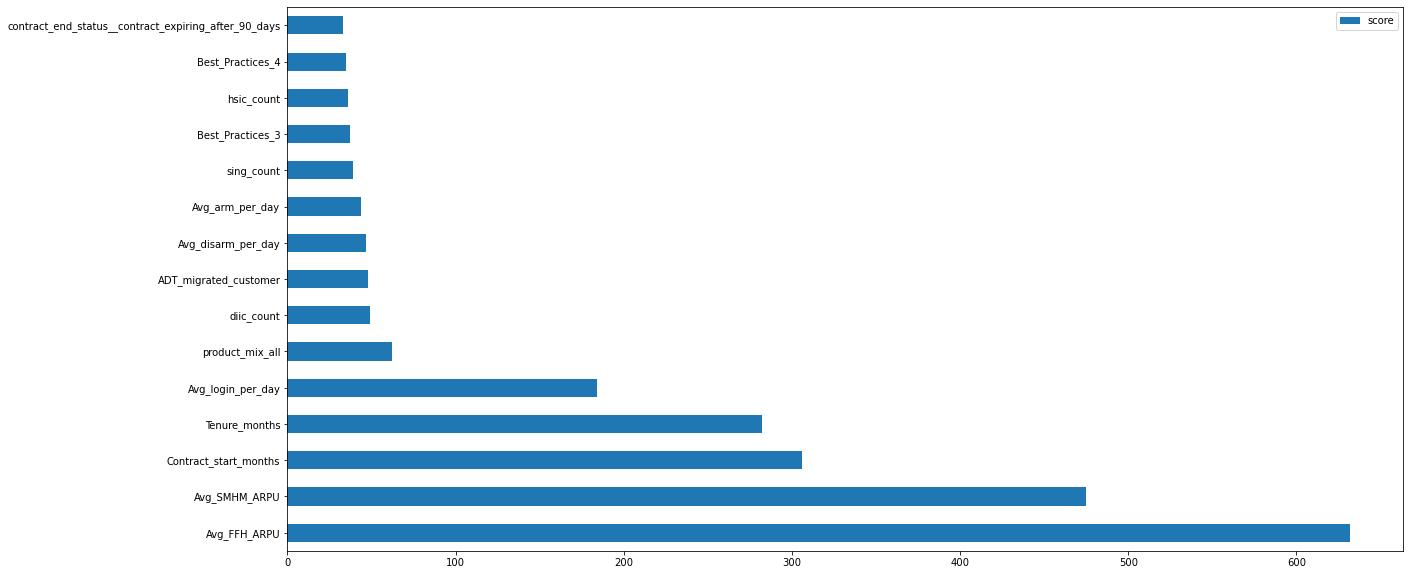

In [186]:
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(15, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


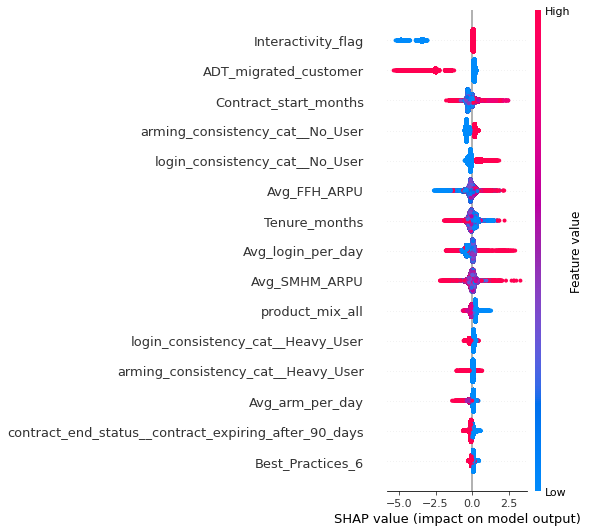

In [187]:
import shap
# model_shap = XGB_final_model.best_estimator_
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train,check_additivity=False)
#%%

shap.summary_plot(shap_values, features=X_train
, feature_names=final_feature_columns,show=False,max_display=15)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


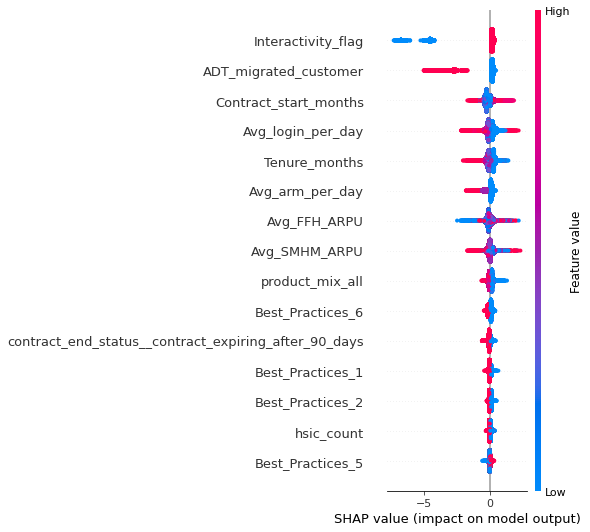

In [110]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_validation,check_additivity=False)
#%%

shap.summary_plot(shap_values, features=X_validation
, feature_names=final_feature_columns,show=False,max_display=15)

In [361]:
# Y_train=Y_train.astype('int')
# Y_validation=Y_validation.astype('int')

In [189]:
import datetime
import joblib

date_time_now=datetime.datetime.now().strftime("%Y%m%d_%I%M%S")
Model_filename_1=Algo+'_'+'SMHM_churn_model'+'_'+date_time_now+'.pkl'
joblib.dump(xgb,Model_filename_1)


['XGB_SMHM_SMHM_churn_model_20230417_073900.pkl']

In [362]:
# X_train=X_train.astype('int')
# X_validation=X_validation.astype('int')

In [686]:
X_train.dtypes

ttv_count                                                  Int64
Avg_arm_per_day                                          float64
hsic_count                                                 Int64
Best_Practices_3                                           Int64
Best_Practices_5                                           Int64
Tenure_months                                              Int64
Best_Practices_1                                           Int64
Contract_start_months                                      Int64
Avg_FFH_ARPU                                             float64
Best_Practices_6                                           Int64
Best_Practice_All                                          Int64
Avg_login_per_day                                        float64
stv_count                                                  Int64
Avg_SMHM_ARPU                                            float64
Best_Practices_2                                           Int64
Best_Practices_4         

In [381]:
Y_train=Y_train.astype('float64')
Y_validation=Y_validation.astype('float64')

In [382]:
X_train['ttv_count']=X_train['ttv_count'].astype('float64')
X_train['sing_count']=X_train['sing_count'].astype('float64')
X_train['hsic_count']=X_train['hsic_count'].astype('float64')
X_train['product_mix_all']=X_train['product_mix_all'].astype('float64')
X_train['diic_count']=X_train['diic_count'].astype('float64')
X_train['stv_count']=X_train['stv_count'].astype('float64')

In [383]:
X_validation['ttv_count']=X_validation['ttv_count'].astype('float64')
X_validation['sing_count']=X_validation['sing_count'].astype('float64')
X_validation['hsic_count']=X_validation['hsic_count'].astype('float64')
X_validation['product_mix_all']=X_validation['product_mix_all'].astype('float64')
X_validation['diic_count']=X_validation['diic_count'].astype('float64')
X_validation['stv_count']=X_validation['stv_count'].astype('float64')

In [459]:
Y_train.dtypes

SMHM_Churn    Int64
dtype: object

In [460]:
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180420 entries, 243252 to 187630
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   SMHM_Churn  180420 non-null  Int64
dtypes: Int64(1)
memory usage: 2.9 MB


In [463]:
Y_train.head()

,SMHM_Churn
243252,0
178901,0
149461,0
115511,0
58339,0


In [480]:
# Y_train_1=Y_train['SMHM_Churn'].astype('int').to_list()
# Y_validation_1=Y_validation['SMHM_Churn'].astype('int').to_list()

In [502]:
# Y_train_1 = Y_train['SMHM_Churn'].astype('int')
# Y_validation_1 = Y_validation['SMHM_Churn'].astype('int')

In [540]:
Y_train_1=np.squeeze(Y_train['SMHM_Churn'].values)
Y_validation_1 = np.squeeze(Y_validation['SMHM_Churn'].values)

In [541]:
# X_train['ttv_count']=X_train['ttv_count'].to_list()
# X_train['sing_count']=X_train['sing_count'].to_list()
# X_train['hsic_count']=X_train['hsic_count'].to_list()
# X_train['product_mix_all']=X_train['product_mix_all'].to_list()
# X_train['diic_count']=X_train['diic_count'].to_list()
# X_train['stv_count']=X_train['stv_count'].to_list()

In [542]:
# X_validation['ttv_count']=X_validation['ttv_count'].to_list()
# X_validation['sing_count']=X_validation['sing_count'].to_list()
# X_validation['hsic_count']=X_validation['hsic_count'].to_list()
# X_validation['product_mix_all']=X_validation['product_mix_all'].to_list()
# X_validation['diic_count']=X_validation['diic_count'].to_list()
# X_validation['stv_count']=X_validation['stv_count'].to_list()

In [543]:
X_train.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)
# X_test.reset_index(drop=True,inplace=True)

In [188]:
# import lightgbm as lgb

# model_lgb = lgb.LGBMClassifier(
#                         n_jobs=-1,
#                         n_estimators=100000,
#                         learning_rate=0.01,
#                         num_leaves=64,
#                         num_threads=4,
#                         max_depth=-1,
#                         tree_learner='serial',
#                         feature_fraction=0.7,
#                         bagging_freq=5,
#                         bagging_fraction=0.7,
#                         verbose=-1,
#                         bagging_seed=11
#                     )


# model_lgb.fit(X_train, Y_train_1, early_stopping_rounds=200, eval_set=[(X_train,Y_train_1),(X_validation, Y_validation_1)],eval_metric=custom_scorer,verbose=500)

In [499]:
Y_train.values.flatten()

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [501]:
Y_train['SMHM_Churn'].unique()

<IntegerArray>
[0, 1]
Length: 2, dtype: Int64